# Database Exploration

This notebook allows for easy exploration of the contents of the /data folder.

It is mainly design for use with the Ninapro databases and databases which are setup in similar fashion.

In [1]:
import src
from scipy.io import loadmat, whosmat
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt 
import os
import pandas as pd
import plotly.express as px
from src import config
from src import *
import re
from src import loadmatNina 
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
import numpy as np
from itertools import combinations
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
import numpy as np
from itertools import combinations
from scipy.io import whosmat
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt




Explore a dataset general information. It will output a summary for each file found in a subject.

In [2]:
# Choose the database to analyze
database = 'DB4'

data_path = f'data/{database}'

# Find the folder named with the convention s + "number"
folder = None
for item in os.listdir(data_path):
    if re.match(r'[sS]\d+', item) or re.match(r'Subject\d+', item):
        folder = item
        break

if folder:
    folder_path = os.path.join(data_path, folder)
    results = []

    # Iterate over all .mat files in the folder
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.mat'):
            file_path = os.path.join(folder_path, file_name)
            info = whosmat(file_path)
            results.append((file_name, info))

    # Create a DataFrame to store the results
    data = {}
    for file_name, info in results:
        for item in info:
            if item[0] not in data:
                data[item[0]] = {}
            data[item[0]][file_name] = item[1:]

    df = pd.DataFrame(data)
    df = df.transpose()
    df.columns.name = 'File Name'

    print(df)
else:
    print("No folder found with the convention s + 'number'")

File Name                 S1_E1_A1.mat             S1_E2_A1.mat  \
emg            ((1239383, 12), single)  ((1760957, 12), single)   
stimulus          ((1239383, 1), int8)     ((1760957, 1), int8)   
subject               ((1, 1), double)         ((1, 1), double)   
repetition        ((1239383, 1), int8)     ((1760957, 1), int8)   
age                   ((1, 1), double)         ((1, 1), double)   
exercise              ((1, 1), double)         ((1, 1), double)   
circumference         ((1, 1), double)         ((1, 1), double)   
frequency             ((1, 1), double)         ((1, 1), double)   
gender                    ((1,), char)             ((1,), char)   
height                ((1, 1), double)         ((1, 1), double)   
weight                ((1, 1), double)         ((1, 1), double)   
laterality                ((1,), char)             ((1,), char)   
sensor                    ((1,), char)             ((1,), char)   
restimulus      ((1239383, 1), double)   ((1760957, 1), double

In [3]:
# Define the .mat file name to load
filename = 'S1_E1_A1.mat'
# Define the subject associated with the file
subject  = 's1'
# Load the .mat file using the loadmatNina function
# Parameters: database, file name, and subject
mat_file = src.loadmatNina(database, filename, subject=subject)

Loaded file: S1_E1_A1.mat
Total test time: 619.6915 seconds
Total test time: 10.328191666666667 minutes
Unique restimulus values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Total EMG samples: 14872596.0
Frequency: 2000 Hz
Summary for the whole file:
        __globals__           emg      stimulus  subject    repetition   age  \
25%             NaN -8.996921e+01  0.000000e+00      1.0  0.000000e+00  29.0   
50%             NaN -4.555057e+00  3.000000e+00      1.0  2.000000e+00  29.0   
75%             NaN  7.687926e+01  8.000000e+00      1.0  4.000000e+00  29.0   
count           0.0  1.487260e+07  1.239383e+06      1.0  1.239383e+06   1.0   
freq            NaN           NaN           NaN      NaN           NaN   NaN   
max             NaN  3.011400e+04  1.200000e+01      1.0  6.000000e+00  29.0   
mean            NaN -5.482289e+00  4.090893e+00      1.0  2.203224e+00  29.0   
min             NaN -2.516700e+04  0.000000e+00      1.0  0.000000e+00  29.0   
std             NaN  7.292349e+0

#### Separar por canales

Rest included in the movement extraction!
Filtered EMG data shape: (97291, 12)
Filtered restimulus data shape: (97291, 1)
test time: 48.6455 seconds
Number of Repetitions: 6


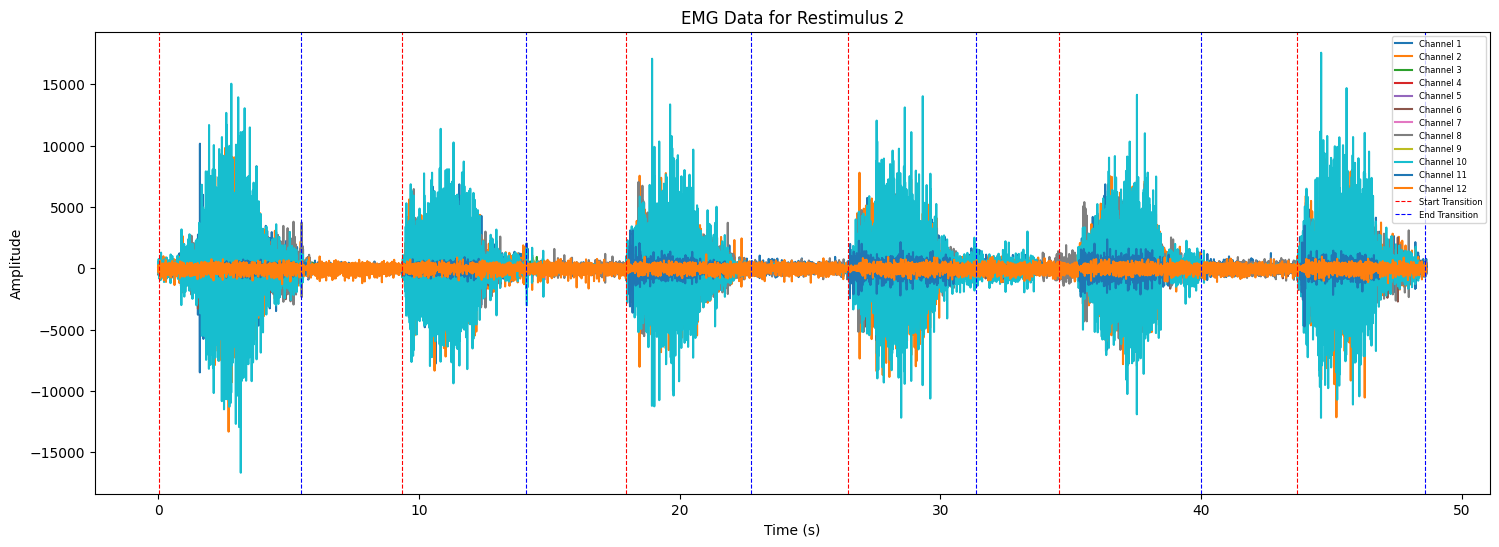

In [4]:
grasp = 2
src.plot_emg_data(database, mat_file, grasp, interactive=False, include_rest=True, use_stimulus=False, addFourier = False, padding = 100)

### Feature Calculation and Database Relabeling for Ninapro

#### Overview
This script demonstrates how to import EMG data and stimulus data, along with a sample calculation of features. The following parameters can be customized:
- **Window size**
- **Padding (zeroes)** 
- **Labeling thresholds**

#### Relabeling Ninapro Databases
To maintain consistency across databases, **Databases 1, 4, and 5** require relabeling to match the convention used in the other databases. The script reorganizes **Exercise A** to appear last in the database, resulting in the following grasp numbering:

- **1 - 17:** Exercise B  
- **18 - 40:** Exercise C  
- **41 - 49:** Exercise D  
- **50 - 61:** Exercise A  
- **0:** Rest  


Below, the image represents the electrodes and channels within the data


- 1-8 are the electrodes equally spaced around the forearm at the height of the radio humeral joint
- 9-10 contain signals from the main activity spot of the muscles flexor and extensor digitorum superficialis
- 11-12 contain signals from the main activity spot of the muscles biceps brachii and triceps brachii.

In [5]:
# Builds a DataFrame and extracts grasp data from the loaded .mat file.
# Parameters:
# - mat_file: previously loaded .mat file.
# - database: database the file belongs to.
# - filename: name of the .mat file.
# - rectify: disables data rectification (False).
# - normalize: enables data normalization (True).
test_df, grasps = src.build_dataframe(mat_file, database, filename, rectify= False, normalize = True)
test_df

New exercise label: A
Relabeling performed for exercise 1 of DB4.
Unique restimulus values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
New restimulus values in Relabeled: [ 0 50 51 52 53 54 55 56 57 58 59 60 61]


,Channel 1,Channel 2,Channel 3,Channel 4,Channel 5,Channel 6,Channel 7,Channel 8,Channel 9,Channel 10,Channel 11,Channel 12,Time (s),subject,re_repetition,stimulus,relabeled
0,-0.080867,-0.026702,-0.184377,0.137110,0.139846,0.129581,0.317491,-0.030544,-0.047140,0.037009,0.227168,-0.273095,0.0000,1,1,0,0
1,-0.015037,-0.036833,0.122537,0.289744,-0.137724,0.061688,0.185393,-0.071280,-0.062437,-0.032694,0.317192,-0.444086,0.0005,1,1,0,0
2,-0.006427,0.005738,-0.046464,0.254572,0.123655,-0.044213,0.190557,-0.108251,-0.167532,0.018729,0.225799,-0.231815,0.0010,1,1,0,0
3,-0.033116,-0.014365,-0.187194,-0.024231,0.042588,0.082919,0.121809,-0.071325,-0.013023,0.004729,0.233412,0.210490,0.0015,1,1,0,0
4,-0.073164,0.055598,0.135732,0.155109,0.048102,0.080464,0.182560,-0.081284,0.030957,0.022244,0.261616,0.086686,0.0020,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1239378,0.149490,-0.017589,-0.007997,0.073302,0.088590,0.561282,0.455076,-0.179261,-0.007832,0.560080,0.250186,0.137384,619.6890,1,1,0,0
1239379,0.098515,-0.033110,-0.161129,0.080156,0.199114,0.437115,0.645930,-0.300915,0.033477,0.508826,0.167348,0.210507,619.6895,1,1,0,0
1239380,0.048467,-0.034961,0.136344,-0.628259,0.363357,0.368981,0.679254,-0.282199,-0.033426,0.439174,0.152553,-0.134368,619.6900,1,1,0,0
1239381,0.003980,0.017148,-0.010167,0.166783,0.226197,0.317011,0.470223,-0.232290,-0.047350,0.330752,-0.117013,-0.264666,619.6905,1,1,0,0


In [6]:
dataframe_new = src.db_utils.filter_data_pandas(test_df, 50, include_rest=False, padding = 0)
dataframe_new

Extracting data without rest!


,Channel 1,Channel 2,Channel 3,Channel 4,Channel 5,Channel 6,Channel 7,Channel 8,Channel 9,Channel 10,Channel 11,Channel 12,Time (s),subject,re_repetition,stimulus,relabeled
7175,-0.107108,0.040313,-0.065545,0.026278,-0.012218,0.165020,0.313963,0.066651,0.137520,0.084501,-0.126716,-1.667177,3.5875,1,1,1,50
7176,-0.212106,0.023810,0.253179,-0.046291,-0.041200,0.182136,0.183117,0.061050,-0.039742,0.153047,-0.125627,-0.762613,3.5880,1,1,1,50
7177,-0.243028,0.003368,-0.209694,-0.097748,0.229128,0.250360,0.089951,0.000052,0.068226,0.180043,0.190132,-0.420801,3.5885,1,1,1,50
7178,-0.188926,0.005273,-0.077164,-0.047693,0.225346,0.185262,0.352294,-0.051849,0.008957,0.143179,-0.124384,-0.261617,3.5890,1,1,1,50
7179,-0.051744,-0.071548,0.221056,-0.152564,0.178701,0.229058,0.113869,-0.055702,-0.064277,0.141193,0.025429,-0.451947,3.5895,1,1,1,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103614,-0.048213,-0.097292,0.053343,0.050900,-0.086696,-0.095185,0.128170,-0.044488,0.066135,-0.043796,-0.097325,0.286280,51.8070,1,6,1,50
103615,0.051276,-0.184330,0.244883,-0.165441,-0.125980,-0.054482,-0.077342,-0.050051,0.014440,-0.064166,-0.107273,0.605593,51.8075,1,6,1,50
103616,0.086472,-0.191611,0.121702,-0.073296,-0.002015,-0.057609,0.019333,-0.058567,-0.006092,-0.021454,0.259579,0.806031,51.8080,1,6,1,50
103617,0.093513,-0.134166,0.074055,0.114227,-0.015193,-0.081079,0.176129,-0.116712,-0.059824,-0.018826,-0.221933,0.915660,51.8085,1,6,1,50


## GENERAL 

In [7]:
# Database name 
database = 'DB4'

# Full path to the database folder
data_path = os.path.abspath(os.path.join('data', database))

# List of subjects, generating names from 's1' to 's10'
subjects = [f's{i}' for i in range(1, 11)]

# Iterate over each subject
for subject in subjects:
    subject_path = os.path.join(data_path, subject)  

    # List of specific file names for each subject
    filenames = [f"{subject.upper()}_E1_A1.mat",
                 f"{subject.upper()}_E2_A1.mat",
                 f"{subject.upper()}_E3_A1.mat"]

    # Iterate over each file
    for filename in filenames:
        file_path = os.path.join(subject_path, filename)
        
        # Check if the file exists
        if os.path.isfile(file_path):
            print(f"Loading file: {file_path}")
            mat_file = loadmatNina(database, filename, subject=subject)
        else:
            print(f"File not found: {file_path}")


Loading file: f:\Lu\CODIGO\IA_ProsthesisUdeA\data\DB4\s1\S1_E1_A1.mat
Loaded file: S1_E1_A1.mat
Total test time: 619.6915 seconds
Total test time: 10.328191666666667 minutes
Unique restimulus values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Total EMG samples: 14872596.0
Frequency: 2000 Hz
Summary for the whole file:
        __globals__           emg      stimulus  subject    repetition   age  \
25%             NaN -8.996921e+01  0.000000e+00      1.0  0.000000e+00  29.0   
50%             NaN -4.555057e+00  3.000000e+00      1.0  2.000000e+00  29.0   
75%             NaN  7.687926e+01  8.000000e+00      1.0  4.000000e+00  29.0   
count           0.0  1.487260e+07  1.239383e+06      1.0  1.239383e+06   1.0   
freq            NaN           NaN           NaN      NaN           NaN   NaN   
max             NaN  3.011400e+04  1.200000e+01      1.0  6.000000e+00  29.0   
mean            NaN -5.482289e+00  4.090893e+00      1.0  2.203224e+00  29.0   
min             NaN -2.516700e+04  0.00000